# Loan Defaulter Prediction using R

In [ ]:
install.packages("ggplot2")
install.packages("glmnet")
install.packages("tidymodels")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’, ‘Rcpp’, ‘RcppEigen’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘warp’, ‘future.apply’, ‘listenv’, ‘parallelly’, ‘lhs’, ‘DiceDesign’, ‘patchwork’, ‘globals’, ‘clock’, ‘gower’, ‘ipred’, ‘timeDate’, ‘furrr’, ‘slider’, ‘doFuture’, ‘future’, ‘GPfit’, ‘modelenv’, ‘dials’, ‘hardhat’, ‘infer’, ‘modeldata’, ‘parsnip’, ‘recipes’, ‘rsample’, ‘rstudioapi’, ‘tune’, ‘workflows’, ‘workflowsets’, ‘yardstick’




In [ ]:
library(ggplot2)
library(glmnet)
library(tidymodels)

Loading required package: Matrix

Loaded glmnet 4.1-8

── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.5      ✔ rsample      1.2.1 
✔ dials        1.2.1      ✔ tibble       3.2.1 
✔ dplyr        1.1.4      ✔ tidyr        1.3.1 
✔ infer        1.0.7      ✔ tune         1.2.1 
✔ modeldata    1.3.0      ✔ workflows    1.1.4 
✔ parsnip      1.2.1      ✔ workflowsets 1.1.0 
✔ purrr        1.0.2      ✔ yardstick    1.3.1 
✔ recipes      1.0.10     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::%||%()     masks base::%||%()
✖ purrr::discard()  masks scales::discard()
✖ tidyr::expand()   masks Matrix::expand()
✖ dplyr::filter()   masks stats::filter()
✖ dplyr::lag()      masks stats::lag()
✖ tidyr::pack()     masks Matrix::pack()
✖ recipes::step()   masks stats::step()
✖ tidyr::unpack()   masks Matrix::unpack()
✖ recipes::update() masks Matrix::update(), stats::update()
• Use suppressPackageStartu

## Data exploration and model

In [ ]:
df.bank = read.csv("bank-loan.csv")
print(head(df.bank))

  age ed employ address income debtinc  creddebt  othdebt default
1  41  3     17      12    176     9.3 11.359392 5.008608       1
2  27  1     10       6     31    17.3  1.362202 4.000798       0
3  40  1     15      14     55     5.5  0.856075 2.168925       0
4  41  1     15      14    120     2.9  2.658720 0.821280       0
5  24  2      2       0     28    17.3  1.787436 3.056564       1
6  41  2      5       5     25    10.2  0.392700 2.157300       0


In [ ]:
# Make default as factor
df.bank$default = as.factor(df.bank$default)

In [ ]:
str(df.bank)

'data.frame':	850 obs. of  9 variables:
 $ age     : int  41 27 40 41 24 41 39 43 24 36 ...
 $ ed      : int  3 1 1 1 2 2 1 1 1 1 ...
 $ employ  : int  17 10 15 15 2 5 20 12 3 0 ...
 $ address : int  12 6 14 14 0 5 9 11 4 13 ...
 $ income  : int  176 31 55 120 28 25 67 38 19 25 ...
 $ debtinc : num  9.3 17.3 5.5 2.9 17.3 10.2 30.6 3.6 24.4 19.7 ...
 $ creddebt: num  11.359 1.362 0.856 2.659 1.787 ...
 $ othdebt : num  5.009 4.001 2.169 0.821 3.057 ...
 $ default : Factor w/ 2 levels "0","1": 2 1 1 1 2 1 1 1 2 1 ...


In [ ]:
# NA values finding
print(colSums(is.na(df.bank)))

     age       ed   employ  address   income  debtinc creddebt  othdebt 
       0        0        0        0        0        0        0        0 
 default 
     150 


In [ ]:
# Since there is no instruction what to do with NA values we just drop them
df = na.omit(df.bank)

In [ ]:
print(colSums(is.na(df)))

     age       ed   employ  address   income  debtinc creddebt  othdebt 
       0        0        0        0        0        0        0        0 
 default 
       0 


In [ ]:
# Summary of the data set
print(lapply(df, FUN = summary))

$age
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  20.00   29.00   34.00   34.86   40.00   56.00 

$ed
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.716   2.000   4.000 

$employ
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   3.000   7.000   8.389  12.000  31.000 

$address
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   3.000   7.000   8.279  12.000  34.000 

$income
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   14.0    24.0    34.0    45.6    55.0   446.0 

$debtinc
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.40    5.00    8.60   10.26   14.12   41.30 

$creddebt
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0117  0.3691  0.8549  1.5536  1.9020 20.5613 

$othdebt
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 0.04558  1.04418  1.98757  3.05821  3.92306 27.03360 

$default
  0   1 
517 183 



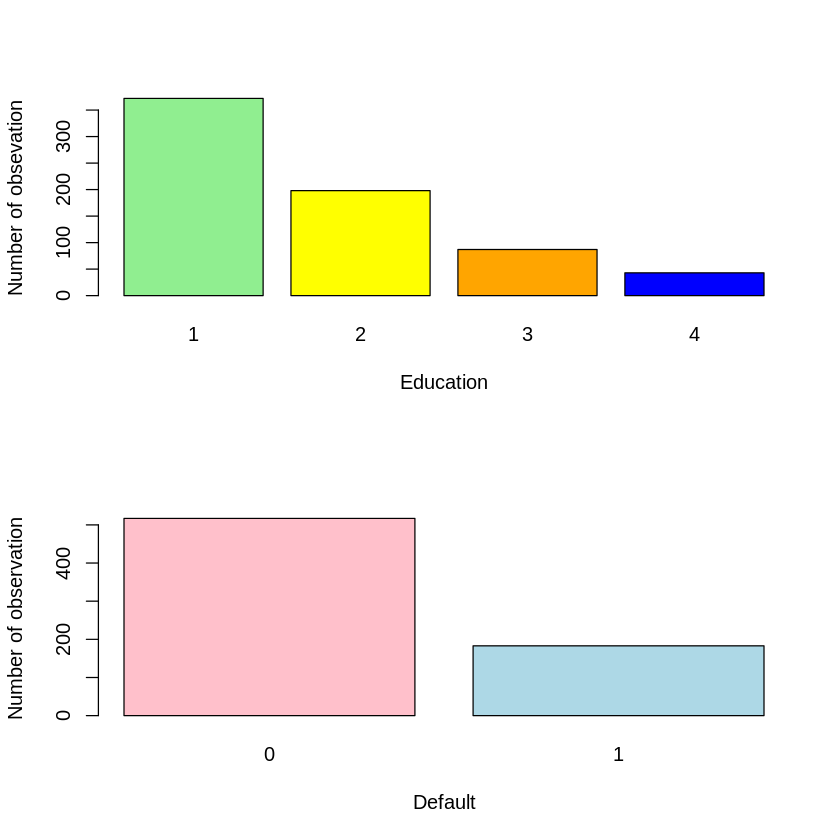

In [ ]:
par(mfrow = c(2,1))
barplot(table(df$ed), col = c("lightgreen", "yellow","orange","blue"),
ylab = "Number of obsevation",
xlab = "Education")
barplot(table(df$default), col = c("pink","lightblue"),ylab = "Number of observation", xlab = "Default")

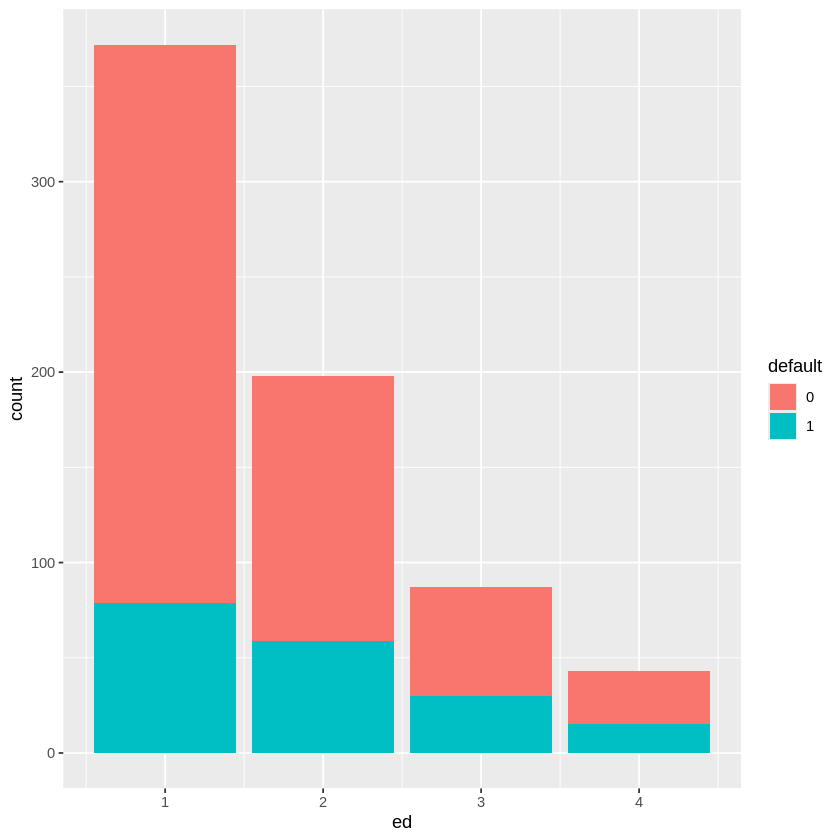

In [ ]:
ggplot(df, aes(ed, fill = default)) +
  geom_bar()

In [ ]:
# train-test split
set.seed(421)
split = initial_split(df, prop = 0.8, strata = default)
train = split %>%
  training()
val_test= split %>%
  testing()

In [ ]:
print(dim(train))

[1] 559   9


In [ ]:
print(dim(val_test))

[1] 141   9


In [ ]:
# Model
log_lr = glm(default ~.,family = "binomial", train)
summary(log_lr)



Call:
glm(formula = default ~ ., family = "binomial", data = train)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.932219   0.692795  -2.789  0.00529 ** 
age          0.050381   0.019602   2.570  0.01017 *  
ed           0.121287   0.141056   0.860  0.38987    
employ      -0.267234   0.037417  -7.142 9.20e-13 ***
address     -0.120499   0.025812  -4.668 3.04e-06 ***
income      -0.006960   0.009751  -0.714  0.47537    
debtinc      0.056472   0.034475   1.638  0.10141    
creddebt     0.625906   0.125897   4.972 6.64e-07 ***
othdebt      0.071951   0.087457   0.823  0.41067    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 642.05  on 558  degrees of freedom
Residual deviance: 449.36  on 550  degrees of freedom
AIC: 467.36

Number of Fisher Scoring iterations: 6


In [ ]:
# Updated model
log_lr = update(log_lr, ~.-income)
summary(log_lr)


Call:
glm(formula = default ~ age + ed + employ + address + debtinc + 
    creddebt + othdebt, family = "binomial", data = train)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.08172    0.65758  -3.166  0.00155 ** 
age          0.04890    0.01948   2.511  0.01205 *  
ed           0.09760    0.13720   0.711  0.47685    
employ      -0.26933    0.03746  -7.190 6.48e-13 ***
address     -0.12067    0.02577  -4.682 2.84e-06 ***
debtinc      0.07227    0.02577   2.805  0.00504 ** 
creddebt     0.57854    0.10273   5.632 1.78e-08 ***
othdebt      0.03262    0.06692   0.487  0.62596    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 642.05  on 558  degrees of freedom
Residual deviance: 449.83  on 551  degrees of freedom
AIC: 465.83

Number of Fisher Scoring iterations: 6


In [ ]:
# Updated model
log_lr = update(log_lr, ~.-othdebt)
summary(log_lr)


Call:
glm(formula = default ~ age + ed + employ + address + debtinc + 
    creddebt, family = "binomial", data = train)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.17853    0.62710  -3.474 0.000513 ***
age          0.04938    0.01946   2.537 0.011169 *  
ed           0.12067    0.12852   0.939 0.347788    
employ      -0.26202    0.03404  -7.698 1.38e-14 ***
address     -0.11976    0.02568  -4.664 3.11e-06 ***
debtinc      0.07972    0.02074   3.844 0.000121 ***
creddebt     0.58010    0.10224   5.674 1.39e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 642.05  on 558  degrees of freedom
Residual deviance: 450.06  on 552  degrees of freedom
AIC: 464.06

Number of Fisher Scoring iterations: 6


In [ ]:
# Final model
log_lr = update(log_lr, ~.-ed)
summary(log_lr)


Call:
glm(formula = default ~ age + employ + address + debtinc + creddebt, 
    family = "binomial", data = train)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.94178    0.57091  -3.401 0.000671 ***
age          0.04940    0.01942   2.544 0.010955 *  
employ      -0.26755    0.03360  -7.962 1.70e-15 ***
address     -0.11783    0.02563  -4.598 4.26e-06 ***
debtinc      0.07730    0.02057   3.758 0.000172 ***
creddebt     0.59609    0.10131   5.884 4.01e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 642.05  on 558  degrees of freedom
Residual deviance: 450.94  on 553  degrees of freedom
AIC: 462.94

Number of Fisher Scoring iterations: 6


In [ ]:
install.packages("caret")
library(caret)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘proxy’, ‘e1071’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘reshape2’


Loading required package: lattice


Attaching package: ‘caret’


The following objects are masked from ‘package:yardstick’:

    precision, recall, sensitivity, specificity


The following object is masked from ‘package:purrr’:

    lift




In [ ]:
prd_Val = predict(log_lr, type='response')
prd_default = ifelse(prd_Val > 0.5, 1, 0)
cnf_m = table(prd=prd_default, act=train$default)
confusionMatrix(cnf_m)

Confusion Matrix and Statistics

   act
prd   0   1
  0 380  73
  1  33  73
                                          
               Accuracy : 0.8104          
                 95% CI : (0.7754, 0.8421)
    No Information Rate : 0.7388          
    P-Value [Acc > NIR] : 4.344e-05       
                                          
                  Kappa : 0.4609          
                                          
 Mcnemar's Test P-Value : 0.0001519       
                                          
            Sensitivity : 0.9201          
            Specificity : 0.5000          
         Pos Pred Value : 0.8389          
         Neg Pred Value : 0.6887          
             Prevalence : 0.7388          
         Detection Rate : 0.6798          
   Detection Prevalence : 0.8104          
      Balanced Accuracy : 0.7100          
                                          
       'Positive' Class : 0               
                                          

In [ ]:
install.packages("rcompanion")
library(rcompanion)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rootSolve’, ‘lmom’, ‘TH.data’, ‘sandwich’, ‘mvtnorm’, ‘expm’, ‘Exact’, ‘gld’, ‘libcoin’, ‘matrixStats’, ‘modeltools’, ‘multcomp’, ‘zoo’, ‘DescTools’, ‘multcompView’, ‘coin’, ‘lmtest’, ‘nortest’



Attaching package: ‘rcompanion’


The following object is masked from ‘package:yardstick’:

    accuracy




In [ ]:
print(nagelkerke(log_lr))

$Models
                                                                                    
Model: "glm, default ~ age + employ + address + debtinc + creddebt, binomial, train"
Null:  "glm, default ~ 1, binomial, train"                                          

$Pseudo.R.squared.for.model.vs.null
                             Pseudo.R.squared
McFadden                             0.297658
Cox and Snell (ML)                   0.289568
Nagelkerke (Cragg and Uhler)         0.424020

$Likelihood.ratio.test
 Df.diff LogLik.diff  Chisq    p.value
      -5     -95.556 191.11 2.2597e-39

$Number.of.observations
          
Model: 559
Null:  559

$Messages
[1] "Note: For models fit with REML, these statistics are based on refitting with ML"

$Warnings
[1] "None"



In [ ]:
install.packages("pROC")
library(pROC)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




Setting levels: control = 0, case = 1

Setting direction: controls < cases



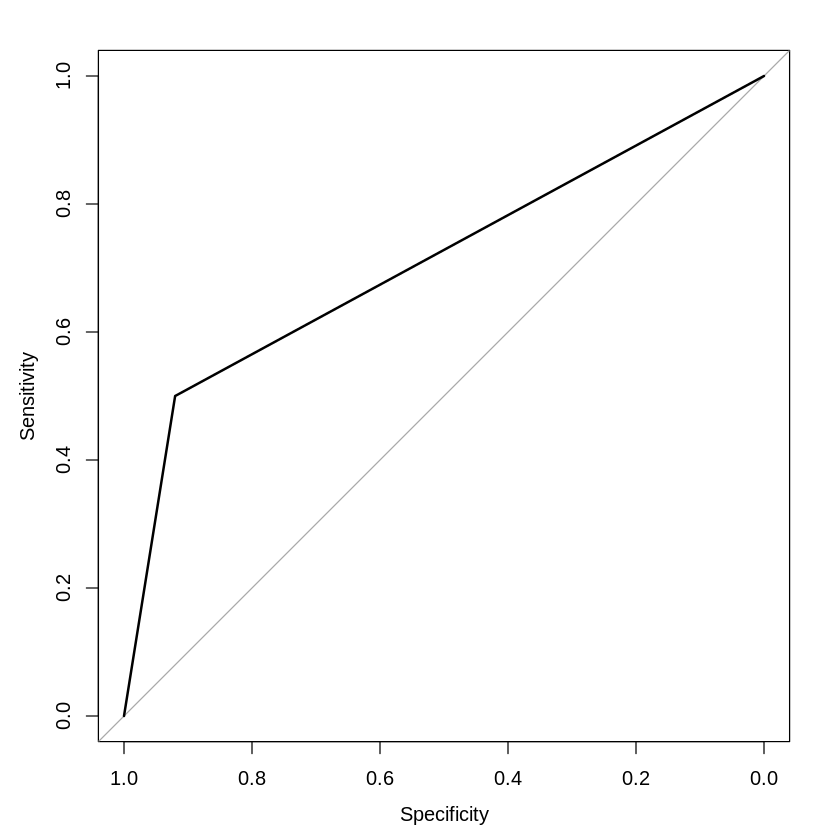

In [ ]:
rocplot = roc(train$default, prd_default)
plot(rocplot)

In [ ]:
prd_val_test = predict(log_lr, val_test, type = "response")
prd_test_default = ifelse(prd_val_test > 0.5, 1, 0)
cnf_mtest = table(prd=prd_test_default, act=val_test$default)
confusionMatrix(cnf_mtest)

Confusion Matrix and Statistics

   act
prd  0  1
  0 98 16
  1  6 21
                                          
               Accuracy : 0.844           
                 95% CI : (0.7734, 0.8996)
    No Information Rate : 0.7376          
    P-Value [Acc > NIR] : 0.001829        
                                          
                  Kappa : 0.5585          
                                          
 Mcnemar's Test P-Value : 0.055009        
                                          
            Sensitivity : 0.9423          
            Specificity : 0.5676          
         Pos Pred Value : 0.8596          
         Neg Pred Value : 0.7778          
             Prevalence : 0.7376          
         Detection Rate : 0.6950          
   Detection Prevalence : 0.8085          
      Balanced Accuracy : 0.7549          
                                          
       'Positive' Class : 0               
                                          